<h2 style="color:red"> OPTIMIZACIÓN CONVEXA</h2>

### Librerías

In [1]:
!pip install cvxpy
!pip install numpy
!pip install opencv-python

### Funciones para calcular los parámetros que usaremos en nuestro modelo

In [2]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# Calculamos A para encontrar la luz del aire

def Airlight(HazeImg, windowSize):
    A = []
    for ch in range(len(HazeImg.shape)):
      kernel = np.ones((windowSize, windowSize), np.uint8)
      minImg = cv2.erode(HazeImg[:, :, ch], kernel)
#       plt.imshow(cv2.erode(HazeImg[:, :, ch], kernel))
#       plt.show()
      A.append(int(minImg.max()))
    return(A)

In [3]:
# Calculamos la función de transmisión para cada pixel. La matriz que retornamos 
# es del mismo tamaño de la imagen de entrada y cada elemento tendra un valor entre 0 y 1

def Transmission(HazeImg, A, C0, C1):
    
#     print("A0",A[0])
#     print(HazeImg[:, :, 0].astype(np.float))
#     print(A[0] - HazeImg[:, :, 0].astype(np.float))
    
    t_b = np.maximum((A[0] - HazeImg[:, :, 0].astype(float)) / (A[0] - C0),
                      (HazeImg[:, :, 0].astype(float) - A[0]) / (C1 - A[0]))
    t_g = np.maximum((A[1] - HazeImg[:, :, 1].astype(float)) / (A[1] - C0),
                      (HazeImg[:, :, 1].astype(float) - A[1]) / (C1 - A[1]))
    t_r = np.maximum((A[2] - HazeImg[:, :, 2].astype(float)) / (A[2] - C0),
                      (HazeImg[:, :, 2].astype(float) - A[2]) / (C1 - A[2]))
    MaxVal = np.maximum(t_b, t_g, t_r)
    transmission = np.minimum(MaxVal, 1)
#     plt.imshow(transmission)
#     plt.show()
    return(transmission)

In [102]:
def plot_results(HazeImg, HazeCorrectedImg):
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
    axes.ravel()
    rgb_img_original = cv2.cvtColor(HazeImg, cv2.COLOR_BGR2RGB)
    rgb_img_dehazed = cv2.cvtColor(HazeCorrectedImg, cv2.COLOR_BGR2RGB)
    axes[0].imshow(rgb_img_original)
    axes[1].imshow(rgb_img_dehazed)
    fig.tight_layout()
    plt.show()

    fig1, axes1 = plt.subplots(nrows=1, ncols=2,figsize=(10,3.5))
    axes1[0].title.set_text("Histograma de colores")
    axes1[0].hist(HazeImg.ravel(),256,[0,256])
    axes1[1].title.set_text("Histograma de colores")
    axes1[1].hist(HazeCorrectedImg.ravel(),256,[0,256])
    fig1.tight_layout()

    fig2, axes2 = plt.subplots(nrows=1, ncols=2,figsize=(10,3.5))

    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            HazeImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[0].plot(bin_edges[0:-1], histogram, color=color)
    fig2.tight_layout()
    axes2[0].title.set_text("Histograma de colores");    
    axes2[1].title.set_text("Histograma de colores");  

    # fig2.tight_layout()
    for channel_id, color in enumerate(colors):
        histogram, bin_edges = np.histogram(
            HazeCorrectedImg[:, :, channel_id], bins=256, range=(0, 256)
        )
        axes2[1].plot(bin_edges[0:-1], histogram, color=color)

    fig2.tight_layout()
    plt.title("Histograma de colores");


### Construcción del modelo usando CVXPY

In [28]:
import cvxpy as cp
from cvxpy.atoms.norm1 import norm1
from cvxpy.atoms.pnorm import pnorm
nombre_im="test7."

def removeHaze(HazeImg,Transmission, A, delta, Regularize = False):
    epsilon = 0.0001
    Transmission = pow(np.maximum(abs(Transmission), epsilon), delta)
#     plt.imshow(Transmission,cmap='gray')
#     plt.show()
#     plt.imshow(Transmission-Transmissionn,cmap='gray')
#     plt.show()
    HazeCorrectedImage = copy.deepcopy(HazeImg)
    for ch in range(len(HazeImg.shape)):
        # Definimos los parámetros para construir el modelo en CVXPY
        I_c = cp.Parameter(HazeImg[:, :, ch].shape)
        I_c.value = HazeImg[:, :, ch]        
        t_c = cp.Parameter(Transmission.shape)
        t_c.value = Transmission
        a_c = cp.Parameter()
        a_c.value = A[ch]

        # Definimos la variable a optimizar, que en este caso es la imagen sin niebla que queremos recuperar
        J_c = cp.Variable(HazeCorrectedImage[:, :, ch].shape)
        J_c.value = HazeCorrectedImage[:, :, ch]

        # Si el canal que se optimiza es el azul se escoge un lamba_2 ligeramente más grande para obtener mejores resultados
        if ch==2:            
            lambda_1 = -0.01
            lambda_2 = 0.0015
        else:
            lambda_1 = -0.01
            lambda_2 = 0.001

        # Definimos la expresión que vamos a minimizar        
        if Regularize:
          expression = I_c-(cp.multiply(J_c,t_c) + a_c*(1-t_c))+(lambda_1*(cp.norm(t_c,p=2).value))+lambda_2*cp.tv(t_c).value
        else:
          expression = I_c-(cp.multiply(J_c,t_c) + a_c*(1-t_c))        
        objective = cp.Minimize(cp.sum_squares(expression))

        # Definimos las restricciones, que en este caso es que cada pixel tenga un valor entre 0 y 255
        constraints = [0 <= J_c, J_c <= 255]
        prob = cp.Problem(objective, constraints)        
        prob.solve()
        print("Optimizando")
        temp=J_c.value
        temp = np.maximum(np.minimum(temp, 255), 0)
        HazeCorrectedImage[:, :, ch] = temp    
    return(HazeCorrectedImage)  

## Evaluación

Ejecutamos el siguiente código para ver un ejemplo de como funciona el problema de reconstrucción de imágenes. Se presenta una imagen de la ciudad de Bogotá en un día nublado y lluvioso.

In [104]:
HazeImg = cv2.imread(nombre_im+"jpg")

# Estimamos la luz del aire. 
# Podemos cambiar el tamaño del kernel que usamos para la erosión de la imagen
windowSize_erode = 25
A = Airlight(HazeImg, windowSize_erode)
# Cotas para el cálculo que la transmisión de luz. Se utilizan las propuestas en el paper
C0=20
C1=300
t = Transmission(HazeImg,A,C0,C1)

# El último parámetro es para definir si se regulariza la imagen o no
DCPDehaze = removeHaze(HazeImg, t, A, 0.5, False)

# cv2.imwrite("DCPdehazed-"+nombre_im+"png",HazeCorrectedImg)


C:\Users\Joluc\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


Optimizando
Optimizando
Optimizando


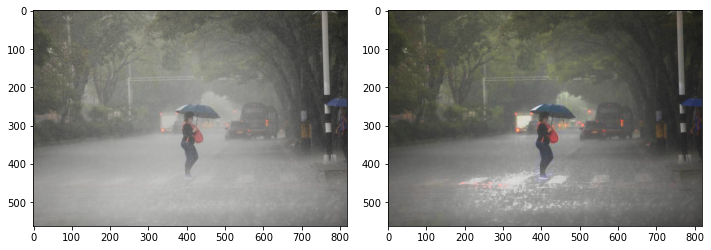

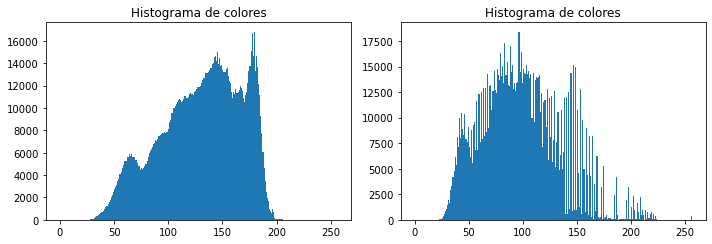

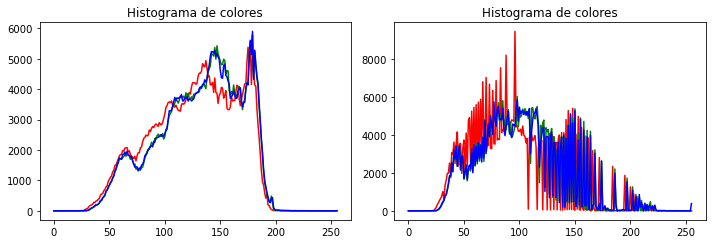

In [106]:
plot_results(HazeImg,DCPDehaze)

<br><br>
<h2 style="color:red"> MÉTODO ROY-CHAUDHURI</h2>

In [6]:
import scipy.io as io
import urllib.request
import matplotlib.pyplot as plt

In [7]:
def TransmissionRC(HazeImg, A):
    one_matrix = np.ones((HazeImg.shape[0],HazeImg.shape[1]))
    t_b = one_matrix-HazeImg[:, :, 0].astype(float)*(0.95/A[0])
    t_g = one_matrix-HazeImg[:, :, 1].astype(float)*(0.95/A[1])
    t_r = one_matrix-HazeImg[:, :, 2].astype(float)*(0.95/A[2])
    MaxVal = np.maximum(t_b, t_g, t_r)
    transmission = np.minimum(MaxVal, 1)
    return(transmission)

In [8]:
def contrastControllerRC(Image):
#     print(Image.shape)
    grayscale = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
#     print(np.min(grayscale))
#     print(np.max(grayscale))
    num=np.max(grayscale)-np.min(grayscale)
    den=int(np.max(grayscale))+int(np.min(grayscale))
    michelson=num/den
#     plt.imshow(grayscale,cmap='gray')
#     plt.show()   
    for ch in range(len(Image.shape)):
        Image[:,:,ch]=Image[:,:,ch]*michelson
    return Image

In [9]:
def removeHazeRC(HazeImg,Transmission, A, delta, Regularize = False):
    epsilon = 0.0001
    A_contrast = [(255-x)/255 for x in A]
    A_contrast = [1-np.max(A_contrast)+x for x in A_contrast]
#     print(A_contrast)
    Transmission = pow(np.maximum(abs(Transmission), epsilon), delta)
#     plt.imshow(Transmission,cmap='gray')
#     plt.show()
#     plt.imshow(Transmission-Transmissionn,cmap='gray')
#     plt.show()
    HazeCorrectedImage = copy.deepcopy(HazeImg)
    for ch in range(len(HazeImg.shape)):
        A_matrix = np.ones((HazeImg.shape[0],HazeImg.shape[1]))    
        A_matrix = A_matrix*A[ch]
        temp=np.divide((HazeImg[:, :, ch]-A_matrix),np.maximum(Transmission, epsilon))+A_matrix
        temp = np.maximum(np.minimum(temp, 255), 0)
#         temp = temp*A_contrast[ch]
        HazeCorrectedImage[:, :, ch] = temp    
#     HazeCorrectedImage = contrastControllerRC(HazeCorrectedImage)
    return(HazeCorrectedImage) 

### Evaluación

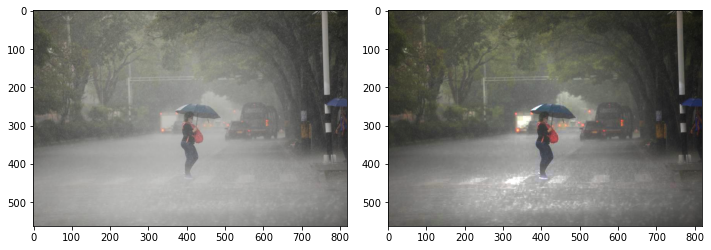

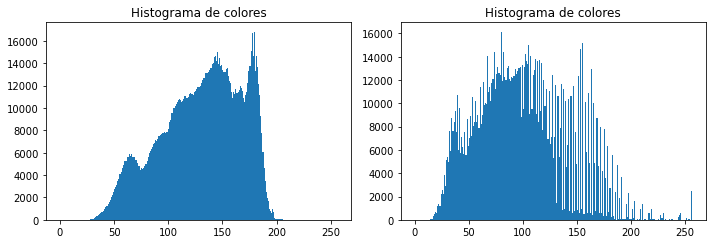

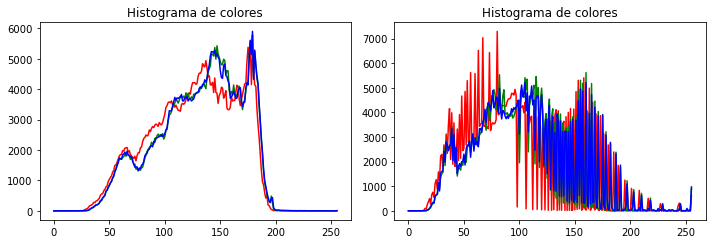

In [108]:
HazeImg = cv2.imread(nombre_im+"jpg")

colors = ("red", "green", "blue")

# create the histogram plot, with three lines, one for
# each color

# Estimamos la luz del aire. 
# Podemos cambiar el tamaño del kernel que usamos para la erosión de la imagen
windowSize_erode = 25
A = Airlight(HazeImg, windowSize_erode)
t = TransmissionRC(HazeImg,A)
# plt.imshow(t,cmap='gray')
# plt.show()
# print(t)
# El último parámetro es para definir si se regulariza la imagen o no
RCDehaze = removeHazeRC(HazeImg, t, A, 0.5, True)

plot_results(HazeImg,RCDehaze)

# cv2.imwrite("RCdehazed-"+nombre_im+"png",HazeCorrectedImg)

 <br><br>
 <h2 style="color:red"> REDES NEURONALES CONVOLUCIONALES (CNN)</h2> 

### Librerías

In [109]:
import tensorflow.compat.v1 as tf
from tensorflow.keras.layers import *
import os, shutil
import glob
import random
from PIL import Image
import cv2

### Hiperparámetros

In [12]:
n_epochs = 10
batch_size = 8
learning_rate = 1e-4
weight_decay = 1e-4

### Funciones auxiliares

In [13]:
def setup_data_paths(orig_images_path,hazy_images_path): 
    orig_image_paths = glob.glob(orig_images_path + "/*.jpg")
    n = len(orig_image_paths) 
    random.shuffle(orig_image_paths)
    train_keys = orig_image_paths[:int(0.90*n)]
    val_keys = orig_image_paths[int(0.90*n):]
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
  
    train_data = []
    val_data = []
  
    hazy_image_paths = glob.glob(hazy_images_path + "\*.jpg")
    for path in hazy_image_paths:        
        label = path.split('\\')[-1]
        orig_path = orig_images_path + "\\" + label.split('_')[0] + '_' + label.split('_')[1] + ".jpg"
        if(split_dict[orig_path] == 'train'):
          train_data.append([path,orig_path])
        else: val_data.append([path,orig_path])  
    return train_data, val_data

def load_image(X):
    X = tf.io.read_file(X)
    X = tf.image.decode_jpeg(X,channels=3)
    X = tf.image.resize(X,(480,640))
    X = X / 255.0
    return X

def showImage(x):
    x = np.asarray(x*255,dtype=np.int32)
    plt.figure()
    plt.imshow(x)
    plt.show()

In [110]:
def create_datasets(train_data,val_data,batch_size):  
    train_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in train_data]).map(lambda x: load_image(x))
    train_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in train_data]).map(lambda x: load_image(x))
    train_ds = tf.data.Dataset.zip((train_ds_hazy,train_ds_orig)).shuffle(100).repeat().batch(batch_size)

    val_ds_hazy = tf.data.Dataset.from_tensor_slices([data[0] for data in val_data]).map(lambda x: load_image(x))
    val_ds_orig = tf.data.Dataset.from_tensor_slices([data[1] for data in val_data]).map(lambda x: load_image(x))
    val_ds = tf.data.Dataset.zip((val_ds_hazy,val_ds_orig)).shuffle(100).repeat().batch(batch_size)

    iterator = tf.compat.v1.data.Iterator.from_structure(tf.compat.v1.data.get_output_types(train_ds),tf.compat.v1.data.get_output_shapes(train_ds));
  
    train_init_op = iterator.make_initializer(train_ds)
    val_init_op = iterator.make_initializer(val_ds)
  
    return train_init_op, val_init_op, iterator


### Diseño de la Red Neuronal Artificial

In [111]:
def haze_net(X):  
    conv1 = Conv2D(3,1,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(X)
    conv2 = Conv2D(3,3,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(conv1)
    concat1 = tf.concat([conv1,conv2],axis=-1)
  
    conv3 = Conv2D(3,5,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(concat1)
    concat2 = tf.concat([conv2,conv3],axis=-1)
  
    conv4 = Conv2D(3,7,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4],axis=-1)
  
    conv5 = Conv2D(3,3,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(stddev=0.02),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(concat3)
    K = conv5
  
    output = ReLU(max_value=1.0)(tf.math.multiply(K,X) - K + 1.0)
    #output = output / 255.0
  
    return output


# Experimental Network with Res-Net type connections
def haze_res_net(X):  
    conv1 = Conv2D(3,1,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(X)
    conv2 = Conv2D(3,3,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(conv1)
    add1 = conv1 + conv2
  
    conv3 = Conv2D(3,5,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(add1)
  
    conv4 = Conv2D(3,7,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(conv3)
    add2 = conv3 + conv4
  
    conv5 = Conv2D(3,3,1,padding="SAME",activation="relu",use_bias=True,kernel_initializer=tf.initializers.random_normal(),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(add2)
    add3 = conv5 + conv1
    K = add3
  
    output = ReLU(max_value=1.0)(tf.math.multiply(K,X) - K + 1.0)
    #output = output / 255.0
  
    return output


In [112]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
np.random.seed(9999)
tf.compat.v1.reset_default_graph()
train_data, val_data = setup_data_paths(os.getcwd()+"/data/orig_images",
                                        os.getcwd()+"/data/hazy_images")
train_init_op, val_init_op, iterator = create_datasets(train_data,val_data,batch_size)
next_element = iterator.get_next()

X = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
Y = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
dehazed_X = haze_net(X)

loss = tf.reduce_mean(tf.square(dehazed_X-Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
trainable_variables = tf.trainable_variables()
gradients_and_vars = optimizer.compute_gradients(loss,trainable_variables)
clipped_gradients = [(tf.clip_by_norm(gradient,0.1),var) for gradient,var in gradients_and_vars]
optimizer = optimizer.apply_gradients(gradients_and_vars)

### Evaluación

In [17]:
tf.reset_default_graph()
train_data, val_data = setup_data_paths(os.getcwd()+"/data/orig_images",
                                        os.getcwd()+"/data/hazy_images")
train_init_op, val_init_op, iterator = create_datasets(train_data,val_data,batch_size)
next_element = iterator.get_next()

X = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
Y = tf.placeholder(shape=(None,480,640,3),dtype=tf.float32)
dehazed_X = haze_net(X)

loss = tf.reduce_mean(tf.square(dehazed_X-Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
trainable_variables = tf.trainable_variables()
gradients_and_vars = optimizer.compute_gradients(loss,trainable_variables)
clipped_gradients = [(tf.clip_by_norm(gradient,0.1),var) for gradient,var in gradients_and_vars]
optimizer = optimizer.apply_gradients(gradients_and_vars)

INFO:tensorflow:Restoring parameters from C:\Users\Joluc\Documents\Jorge\UNAL\2022-2\Numerico\image-dehazing/models/model_checkpoint_7.ckpt


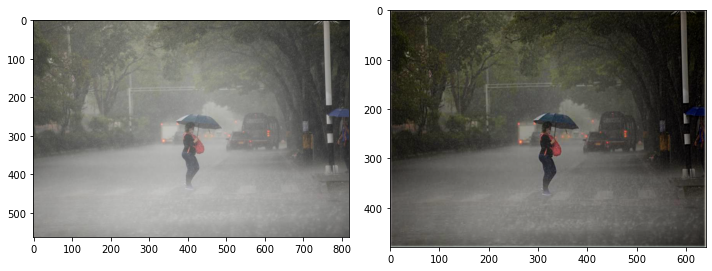

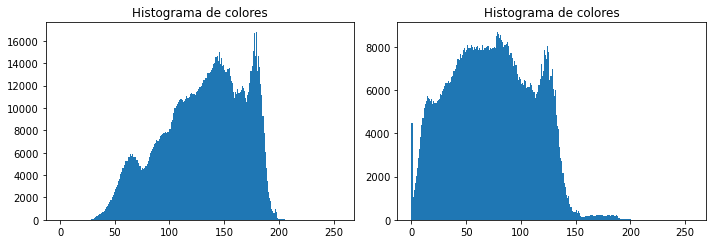

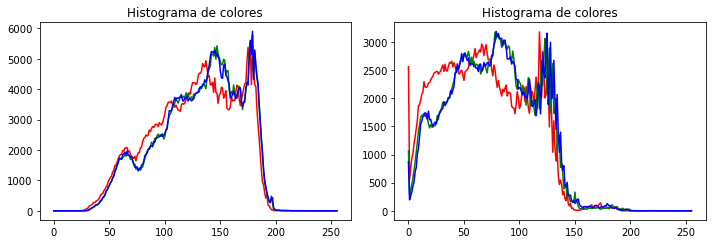

In [117]:
saver = tf.train.Saver();
train_data, val_data = setup_data_paths(os.getcwd()+"/data/orig_images",
                                        os.getcwd()+"/data/hazy_images")

test_input_folder = os.getcwd()+"/test_images"
test_output_folder = os.getcwd()+"/dehazed_test_images"

if not os.path.exists(test_output_folder):
  os.mkdir(test_output_folder)
  
file_types = ['jpeg','jpg']

with tf.Session() as sess:
    saver.restore(sess,os.getcwd()+'/models/model_checkpoint_7.ckpt');
    test_image_paths = []
    for file_type in file_types:
        test_image_paths.extend(glob.glob(test_input_folder+"/*."+file_type));


    for path in test_image_paths:
        image_label = path.split(test_input_folder)[-1][1:]
        if nombre_im!=image_label[:-3]:
            continue
        image = Image.open(path)
        image = image.resize((640, 480))
        image = np.asarray(image) / 255.0
        image = image.reshape((1,) + image.shape)
        dehazed_image = sess.run(dehazed_X,feed_dict={X:image,Y:image});
                
        dehazed_image = np.asarray(dehazed_image[0] * 255,dtype=np.uint8)
        mpl.image.imsave(test_output_folder + "/" + 'dehazed_' + image_label, dehazed_image)
        #Para guardar la imagen en la carpeta principal
        
        mpl.image.imsave("CNNdehazed-"+nombre_im+"png", dehazed_image)
        HazeImg = cv2.imread(path)
        HazeCorrectedImg = cv2.imread("CNNdehazed-"+nombre_im+"png")
        plot_results(HazeImg,HazeCorrectedImg)



 <br><br>
 <h2 style="color:red"> FOURIER (CNN)</h2> 

In [118]:
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist

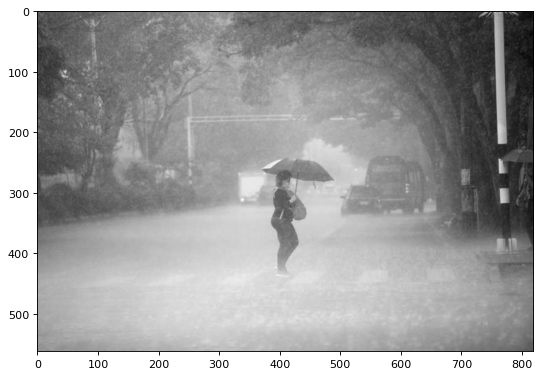

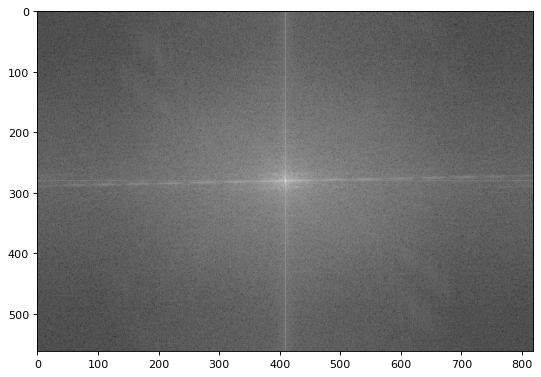

In [139]:
dark_image = imread(nombre_im+"jpg")

dark_image_grey = rgb2gray(dark_image)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(dark_image_grey, cmap='gray');

dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(dark_image_grey))
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(dark_image_grey_fourier)), cmap='gray');

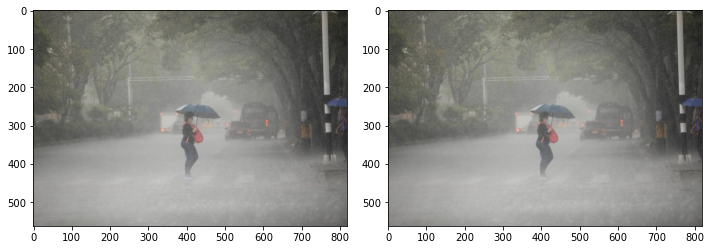

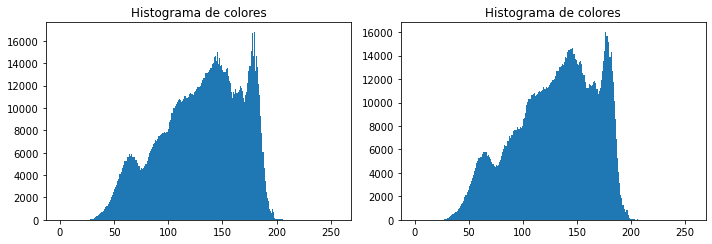

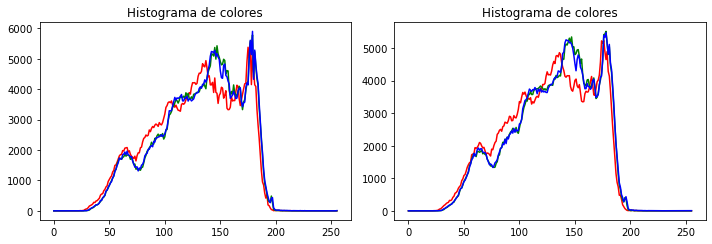

In [140]:
def fourier_transform_rgb(image):
    transformed_channels = []
    for i in range(3):
        rgb_fft = np.fft.fftshift(np.fft.fft2((image[:, :, i])))
        rgb_fft[:225, 235:237] = 1
        rgb_fft[-225:,235:237] = 1
        transformed_channels.append(abs(np.fft.ifft2(rgb_fft)))
    
    final_image = np.dstack([transformed_channels[0].astype(int), 
                             transformed_channels[1].astype(int), 
                             transformed_channels[2].astype(int)])
    cv2.imwrite("FFT"+nombre_im+"png", final_image)
    return final_image
    

FourierDehaze = fourier_transform_rgb(HazeImg)
plot_results(HazeImg,cv2.imread("FFT"+nombre_im+"png"))

# Conclusiones

# Referencias

https://github.com/Utkarsh-Deshmukh/Single-Image-Dehazing-Python/blob/master/src/removeHaze.py

https://www.cv-foundation.org/openaccess/content_iccv_2013/papers/Meng_Efficient_Image_Dehazing_2013_ICCV_paper.pdf

https://www.researchgate.net/publication/307516271_Convex_optimization_for_fast_image_dehazing 

https://www.researchgate.net/publication/221110862_Fast_Visibility_Restoration_from_a_Single_Color_or_Gray_Level_Image

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8323906/